First move to the directory where the python files for image analysis are stored.

In [1]:
pushd /home/kuhlmanlab/Documents/GitHub/microscopyimageprocessing/

/home/kuhlmanlab/Documents/GitHub/microscopyimageprocessing


['~/Documents/Microscope Images/27 March 2017 Mykola ME121 images']

Then import the necessary python libraries (including our custom collections of helper functions) and set up our matplotlib plotting options.

In [2]:
import copy
import matplotlib as mpl
mpl.rcParams["axes.grid"] = False
mpl.rcParams["image.cmap"] = "viridis"
mpl.rcParams["image.interpolation"]="nearest"
mpl.rcParams["image.origin"] = "lower"
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipyd
import numpy as np
import skimage.morphology as skmo
import skimage.measure as skme
import skimage.io as skio
import skimage.transform as sktr

import visualization as mvis
import segmentation as mseg
import illuminationinterpolation as illint
import spotfinding_prototype as spf

NOTE: beolow command allows us to go back to the directory in which the notebook is stored in. Simply drop the notebook along with the data in the same folder and you're good to go.

In [3]:
popd

/home/kuhlmanlab/Documents/Microscope Images/27 March 2017 Mykola ME121 images
popd -> ~/Documents/Microscope Images/27 March 2017 Mykola ME121 images


# Aligning the DS-Fi2 camera to the DU-897 camera

First we need to load images of beads for aligning the camera and finding the transformations relating the coordinates between different types of images. beads_folder_name is the filepath to the folder with the images of beads we are analyzing. beads_name is a blob patterned string that should match the names of files of bead images.

In [4]:
beads_folder_name = "/home/kuhlmanlab/Documents/Microscope Images/27 March 2017 Mykola ME121 images/(04-05-17) NS121 - 10microM IPTG/"
beads_name = "*beads"
beads_pc = skio.ImageCollection(beads_folder_name+beads_name+"*c2*c1.tif")
beads_TIRF = skio.ImageCollection(beads_folder_name+beads_name+"*c1*c2.tif")
beads_BF = skio.ImageCollection(beads_folder_name+beads_name+"*c1*c1.tif")

Then inspect the images to make sure they've loaded and they look good.

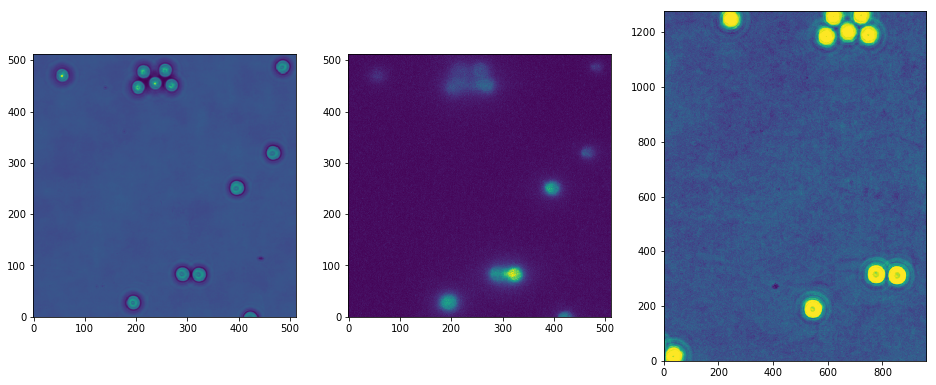

In [5]:
mvis.inspectImages([beads_BF, beads_TIRF, beads_pc], (16,10))

Then find the background illumination in the brightfield and phase contrast channels and normalize them by dividing each image by the background illumination.

In [6]:
beads_BF_bg = mseg.findMedianBg(beads_BF)
beads_pc_bg = mseg.findMedianBg(beads_pc)
beads_BF_n = [image / beads_BF_bg for image in beads_BF]
beads_pc_n = [image / beads_pc_bg for image in beads_pc]

Next before the phase contrast and TIRF images can be aligned, we need to find the beads. This function does it for brightfield, but a simple threshold will work for phase contrast or TIRF. Always inspect the masks to make sure they look good. It's ok if a few beads are missed.

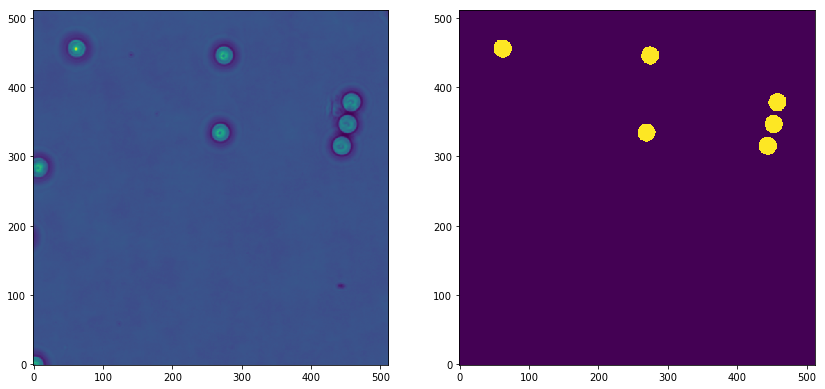

In [7]:
threshes = [mseg.localMinLeftOfGlobalMax(image) for image in beads_BF_n]
thr1 = .9*np.max(np.array(threshes))
bead_BF_masks = [mseg.findBeadsBF(image,thr1) for image in beads_BF_n]
beads_BF_masks = mseg.removeNonCirles(bead_BF_masks,10)
mvis.inspectImages([beads_BF_n, beads_BF_masks],figsize=(14,7))

The phase contrast channel is a lot easier to find the masks for. A high threshold usually works. Inspect these masks next to the brightfield masks. We'll need a good field of view for alignment.

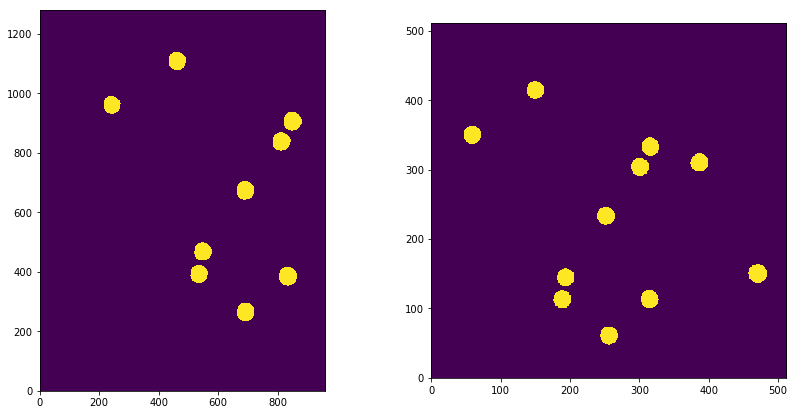

In [14]:
bead_pc_masks = [image>240 for image in beads_pc_n]
bpcm = [skmo.remove_small_holes(mask,min_size=1000) for mask in bead_pc_masks]
bpcm = [skmo.remove_small_objects(mask, min_size=1000) for mask in bpcm]
mvis.inspectImages([bpcm, bead_BF_masks],(14,7))

Once you've picked a field of view, the findRegionCenters helper function will find the centers of the beads in a mask.

In [15]:
index2=9
BF2pc_align_mask = bead_BF_masks[index2]
PC_align_mask = bpcm[index2]
BF2pc_centers = mseg.findRegionCenters(BF2pc_align_mask)
PC_centers = mseg.findRegionCenters(PC_align_mask)

/home/kuhlmanlab/anaconda3/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


You'll need to loop through the next two cells until the lines drawn between the two images are matching beads up correctly. The first cell is used to add, removem and rearrange the order of bead centers from the lists of centers to be matched between cameras.

In [32]:
BF2pc_centers_cl = BF2pc_centers[[0,2,1,3]]
PC_centers_cl = PC_centers[[0,1,2,3]]

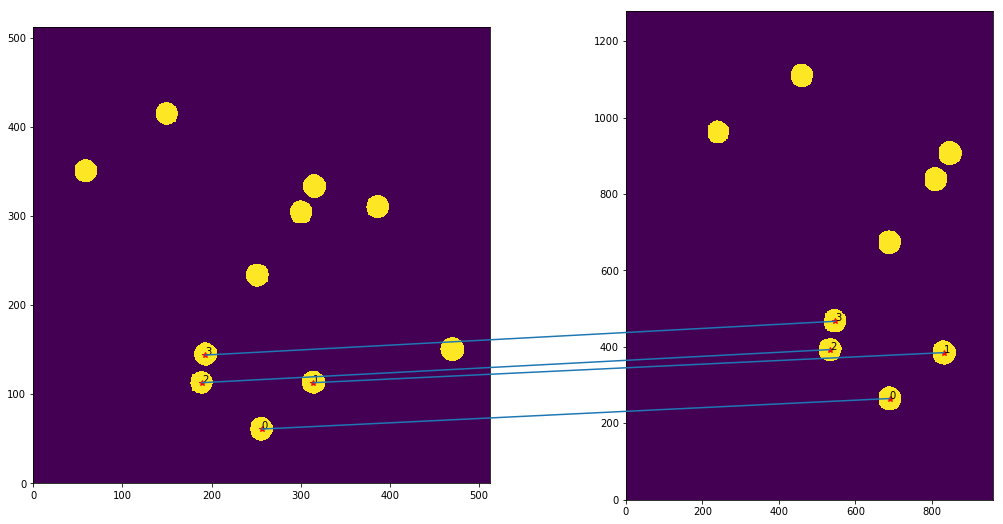

In [33]:
mvis.showKeypointpairs(BF2pc_align_mask, PC_align_mask, BF2pc_centers_cl, PC_centers_cl)

Once the beads are paired up well, skimage can easily find the geometric transform between them.

It's good to print out the transform because we may need to adjust it by hand later down. We also make a copy of it so we don't adjust the original transform skimage found

[[  2.37343903e+00  -6.95636839e-02   1.38318101e+02]
 [  6.95636839e-02   2.37343903e+00   7.81260232e+01]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


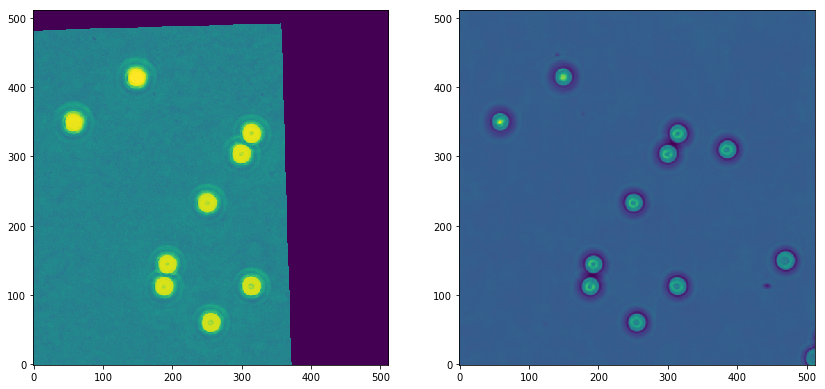

In [34]:
camera_transform_p = sktr.SimilarityTransform()
camera_transform_p.estimate(BF2pc_centers_cl,PC_centers_cl)
beads_PC_warped = mseg.warpIm2Im(beads_pc_n[index2],beads_BF_n[index2],camera_transform_p)
mvis.showImages([beads_PC_warped, beads_BF_n[index2]],(14,7))
total_transform = sktr.SimilarityTransform()
total_transform.params = copy.deepcopy(camera_transform_p.params)
print(total_transform.params)

# Finding the illumination field
Now that we've found the alignment between the different types of images; the beads can be used as a reference to find the illumination field which can correct intensities for the unevenness of the TIRF illumination field.

First we find masks for each bead. We can use brightfield masks for this or warp the phase contrast masks into brightfield coordinates. Using the phase contrast masks will lose some information on the illumination field but we only consider e. coli we see in phase contrast anyways so that lost information is irrelevant. Making masks from the TIRF directly is difficult and error prone.

We estimate the TIRF illumination by an average of the brightness of the beads weighted by distance from the point being considered. We need an estimate of the zero signal. We can get an estimate of that by subtracting the minimum intensity pixel from all intensities.

In [35]:
beads_label = [skme.label(mask) for mask in bead_BF_masks]
beads_rprops_raw = [skme.regionprops(label, TIRF) for label, TIRF in zip(beads_label, beads_TIRF)]
beads_plist = mseg.properties2list(beads_rprops_raw,['mean_intensity','area','centroid'])
zero_signal = np.median(np.array([np.min(image) for image in beads_TIRF]))

print('There are', len(beads_plist['mean_intensity']), 'beads.')
print('The mean intensity of the beads is', '%.0f' % np.mean(beads_plist['mean_intensity']), '.')
print('The standard deviation of intensity of the beads is', 
      '%.0f' % np.std(beads_plist['mean_intensity']), '.')
print('The mean area of the beads is', '%.0f' % np.mean(beads_plist['area']), '.')
print('The standard deviation of area of the beads is', '%.0f' % np.std(beads_plist['area']), '.')
print('The zero signal is', zero_signal, '.')

There are 266 beads.
The mean intensity of the beads is 9552 .
The standard deviation of intensity of the beads is 4760 .
The mean area of the beads is 514 .
The standard deviation of area of the beads is 50 .
The zero signal is 696.0 .


It's always good to look at the estimated TIRF illumination. It shouldn't look too blocky.

It's also good to print out the minimum and maximum relative intensities in illumination. Make sure they are both positive and not too low!

The brightest relative intensity is 1.93 .
The dimmest relative intensity is 0.26 .
This is a factor of 7.34 between the brightest and dimmest areas.


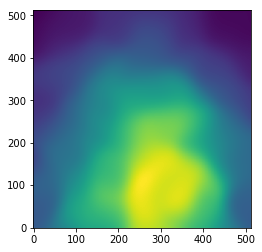

In [36]:
bead_gauss_dfunc = illint.createGaussianDistFunc(beads_plist['centroid'],
                                                 beads_plist['mean_intensity'] - np.mean(zero_signal),40)
bead_TIRF_bg_gaus = illint.evaluateDistsBox(512,512,bead_gauss_dfunc)
bead_TIRF_bg_gaus = bead_TIRF_bg_gaus / np.mean(bead_TIRF_bg_gaus)

plt.imshow(bead_TIRF_bg_gaus)

bg_max = np.max(bead_TIRF_bg_gaus)
bg_min = np.min(bead_TIRF_bg_gaus)
print('The brightest relative intensity is', '%.2f' % bg_max, '.')
print('The dimmest relative intensity is', '%.2f' % bg_min, '.')
print('This is a factor of', '%.2f' % (bg_max/bg_min), 'between the brightest and dimmest areas.')

Then normalize the TIRF images of the beads by subtracting the zero signal and dividing by the illumination.

The distribution of beads intensities should have one big peak or plateau.

After illumination correction, the mean intensity of the beads is 9062 +- 91


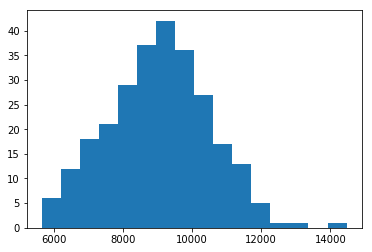

In [37]:
beads_TIRF_n = [np.clip((image - np.mean(zero_signal)),0,np.inf)/bead_TIRF_bg_gaus for image in beads_TIRF]
beads_rprops_n = [skme.regionprops(label, TIRF) for label, TIRF in zip(beads_label, beads_TIRF_n)]
beads_plist_n = mseg.properties2list(beads_rprops_n,['mean_intensity','area','centroid'])
n_beads = len(beads_plist_n['mean_intensity'])
plt.hist(beads_plist_n['mean_intensity'],bins=np.sqrt(n_beads).astype('int32'));
bead_mean_n = np.mean(beads_plist_n['mean_intensity'])
bead_stderr_n = np.std(beads_plist_n['mean_intensity'])/np.sqrt(n_beads)
print('After illumination correction, the mean intensity of the beads is',
      '%.0f' % bead_mean_n,'+-', '%.0f' % bead_stderr_n)

# Identifying the *e. coli* in phase contrast
First we import all the images of *e. coli* and use the phase contrast images to separate the cells from the background. We also use the illumination field gained from the beads to correct the illumination in the e. coli TIRF images.

In [38]:
cell_folder_name = "/home/kuhlmanlab/Documents/Microscope Images/27 March 2017 Mykola ME121 images/(04-05-17) NS121 - 10microM IPTG/"
cell_name = "*cells"
ecoli_TIRF = skio.ImageCollection(cell_folder_name+cell_name+"*c2*c1.tif")
ecoli_pc = skio.ImageCollection(cell_folder_name+cell_name+"*c1*c1.tif")

Always inspect imported images.

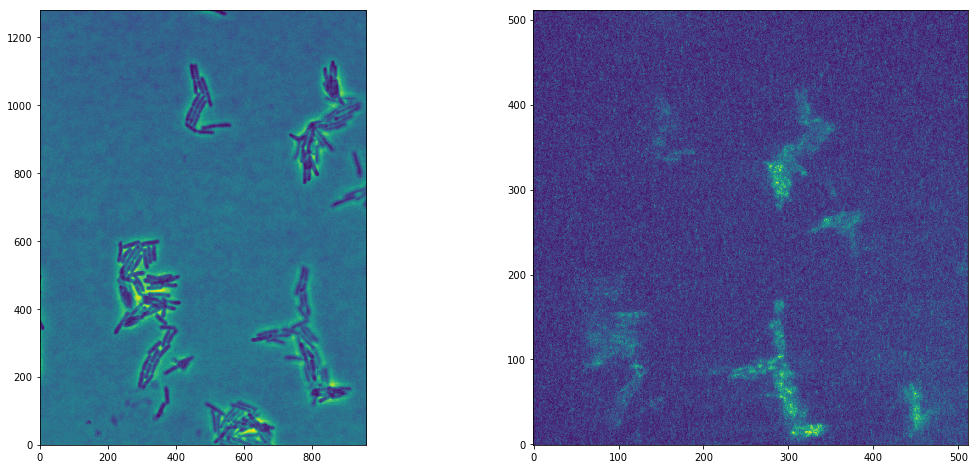

In [39]:
mvis.inspectImages([ecoli_pc,ecoli_TIRF],(18,8))

This next function does the illumination correction for the e. coli phase contrast images and also nonlocal means denoising (using opencv library) on the phase contrast. This denoising is important to getting a good result from thresholding to find the e. coli. The denoising will generally give a warning about loss of precision upon converting float64 to uint8. Do not worry about this, phase contrast intensities are not used for quantification so it doesn't matter.

The TIRF images are normalized by subtracting the zero signal and dividing by the illumination field found from the beads.

Once we've normalized the images, it's time to threshold the phase contrast images. The automated thresholding followed by cleaning up any objects too small to be e. coli works pretty well, but goes wonky occasinally so we'll have to manually drop any images with bad segmentation.

In [40]:
ecoli_pc_norm = mseg.normAndDenoisePc(ecoli_pc)

ecoli_TIRF_norm = [np.clip((image - np.mean(zero_signal)),0,np.inf) / bead_TIRF_bg_gaus for image in ecoli_TIRF]

b_masks_cl = [mseg.thresholdMask(image,min_size=300) for image in ecoli_pc_norm]

/home/kuhlmanlab/anaconda3/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


Of course, we inspect the masks as we inspect everything else. The index on the slider of masks that look bad should go into the indices to blank function of the cell after.

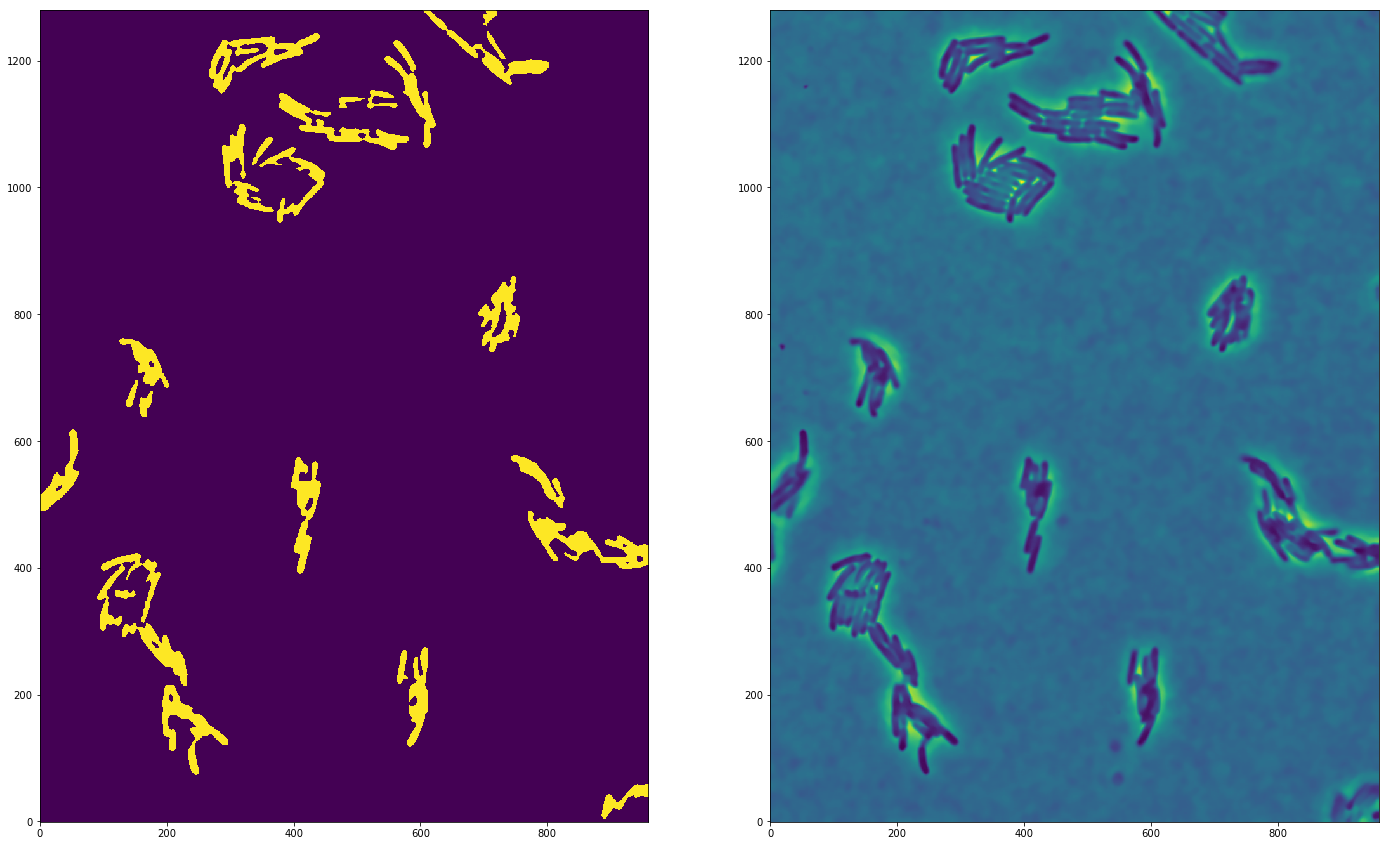

In [41]:
mvis.inspectImages([b_masks_cl,ecoli_pc_norm],(24,16))


Then we drop any images with bad segmentation. You can only drop badly missegmented images or be extremely aggressive (as in this example) in dropping any images with even suspected missegmentations as long as you're consistent about it.

In [42]:
indices_to_blank = [0,8,9,10,11,13,15,16,18,19,26,27,28,29,30,31,40,41,42,47,48,49,50,53,54,55,60,61,63,64,65,66,67,68,69,71,73,74,75,76,77,78,94]
for index in indices_to_blank:
    b_masks_cl[index] = np.zeros_like(b_masks_cl[index])

# Inspecting aligment and making small corrections to misalignment.

Next I use the masks for *e. coli* from phase contrast and transform them to align to the TIRF and see how well they line up. I then tweak the parameters of the transformation by hand using the sliders until the alignment is satisfactory to my eyes.

In [44]:
camera_transform_ec = copy.deepcopy(total_transform)
tabwidget = mvis.adjustAlignment(ecoli_TIRF,b_masks_cl,camera_transform_ec)
ipyd.display(tabwidget)

The transform looks good.

In [45]:
camera_transform_ec.params

array([[  2.37343903e+00,  -6.95636839e-02,   1.38318101e+02],
       [  6.95636839e-02,   2.37343903e+00,   7.81260232e+01],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

Next we make labeled arrays from the phase contrast masks and then only after labeling, warp them into the TIRF coordinates (otherwise we accidentally might fuse separated cells since there are more pixels per area in phase contrast than in TIRF).

In [46]:
ec_labels = [skme.label(mask) for mask in b_masks_cl]
ec_labels_w = [mseg.warpIm2Im(label,ecoli_TIRF[0],camera_transform_ec) for label in ec_labels]
ec_pc_w = [mseg.warpIm2Im(image,ecoli_TIRF[0],camera_transform_ec) for image in ecoli_pc_norm]

# Determining the mean signal (brightness per pixel in a cell)

Now the only thing that remains is to use the warped phase contrast masks and normalized TIRF images to find the distribution of e. coli intensities.

The mean intensity of the e. coli is 1245 +- 15


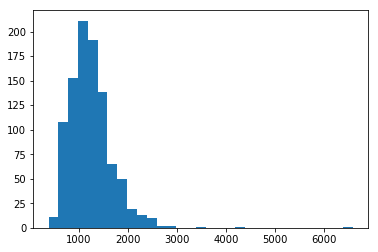

In [47]:
ec_rprops = [skme.regionprops(label,TIRF) for label, TIRF in zip(ec_labels_w, ecoli_TIRF_norm)]
ec_intensities = mseg.properties2list(ec_rprops, ['mean_intensity'])['mean_intensity']
n_ec = len(ec_intensities)
plt.figure()
urg = plt.subplot(111)
urg.hist(ec_intensities,bins=np.sqrt(n_ec).astype('int32'));

ec_meanintensity = np.mean(ec_intensities)
ec_stderrintensity = np.std(ec_intensities)/np.sqrt(n_ec)
print('The mean intensity of the e. coli is', '%.0f' % ec_meanintensity,'+-', '%.0f' % ec_stderrintensity)

### Comparing the signal to an objective standard
To make the signal meaningful for comparison, we have to compare it to the brightness of the beads on the same slide.

The ecoli mean intensity is estimated to be 0.137, with left and right standard erors of  (0.136, 0.139).
The standard deviation over the mean is 0.364.


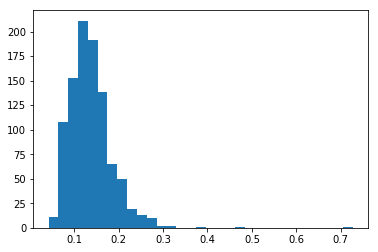

In [48]:
ec_intensities_n = ec_intensities / bead_mean_n

plt.hist(ec_intensities_n,bins=np.sqrt(n_ec).astype('int32'));

ec_meanintensity_n = ec_meanintensity / bead_mean_n
ec_meanintensity_n_lefterr = (ec_meanintensity)/(bead_mean_n + bead_stderr_n)
ec_meanintensity_n_righterr = (ec_meanintensity)/(bead_mean_n - bead_stderr_n)
print('The ecoli mean intensity is estimated to be', '%.3f,' %(ec_meanintensity_n),
      'with left and right standard erors of ', '(%.3f,' %(ec_meanintensity_n_lefterr), 
      '%.3f).' %(ec_meanintensity_n_righterr))

ec_stdintensity_n = np.std(ec_intensities_n)
print('The standard deviation over the mean is', '%.3f.' %(ec_stdintensity_n/ec_meanintensity_n))

# Spot Finding

NEW IN VERSION 2: First we expand the masks and remove holes from the insides of colonies to make sure we're covering all the e. coli for spot finding. Below step yuields images of bacterial clusters with the bacground removed (i.e cut out).

In [49]:
from skimage._shared._warnings import expected_warnings
with expected_warnings(['Only one label']):
    full_masks = [skmo.remove_small_holes(skmo.binary_dilation(image,selem=skmo.disk(10)),min_size=2500)
              for image in b_masks_cl]

    full_masks_w = [mseg.warpIm2Im(mask, ecoli_TIRF[0],camera_transform_ec) for mask in full_masks]

full_masks_label_w = spf.spotfindingLabels(full_masks, ecoli_TIRF[0], camera_transform_ec)

return_dict = spf.regionImagesAndIntensities(full_masks_label_w, ec_pc_w, ecoli_TIRF_norm)
pc_regions = return_dict['pc']
TIRF_regions = return_dict['TIRF']
intensities = return_dict['intensities']

Sets up the file where well save the manual thresholding data (i.e. what we create with manual spot finding program). In the below command we create a separate file (saved in the same directory as the notebook)

In [69]:
manual_thresholding_file = cell_folder_name+"manual_thresholding.npz"
try:
    manual_thresholding_output = np.load(manual_thresholding_file)
    thresholds_loaded = manual_thresholding_output['thresholds']
    overlays_loaded = manual_thresholding_output['overlays']
    start_region = manual_thresholding_output['start_region']
except FileNotFoundError:
    thresholds_loaded = None
    overlays_loaded = None
    start_region=0

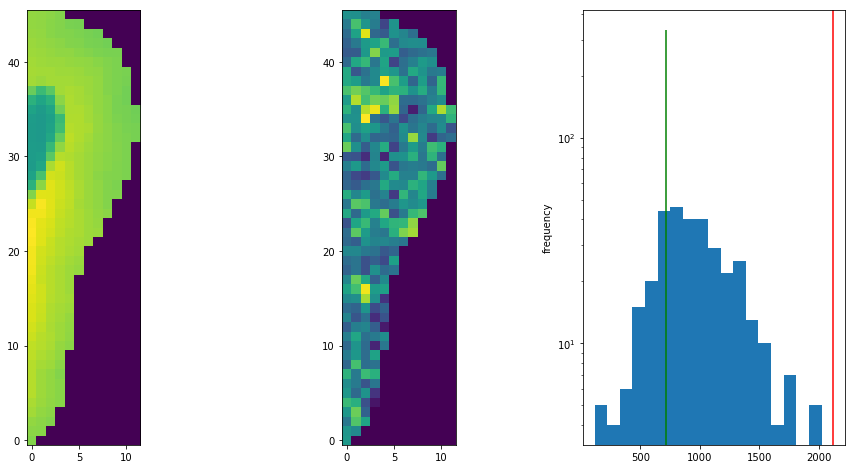

In [70]:
manual_thresher = spf.manualSpotThresholder(pc_regions, TIRF_regions, intensities,(16,8), thresholds_loaded,
                                           overlays_loaded, start_region)
ipyd.display(manual_thresher.box)

Cycle through the first 100 images making sure that the proper threshold value is set so that the program picks up the TIRF fluorescent activity as red spots.

Consider the below function as a "save" command. You could run it when you have to leave and do not want to loose your thresholding analysis process. You can come back to the code and the threshold values are preserved. It would be wise to document somehwere the index of the picture you last analyzed. 

In [71]:
np.savez(manual_thresholding_file, thresholds=manual_thresher.thresholds, overlays=manual_thresher.overlays,
         start_region=manual_thresher.r_slider.value)

In the bottom line there are cutoffs for the number of images analyzed. In this case its [0,100] which means: images 0 -> 100 will be analyzed. The function titled "enough" is implemented if there is less than 100 viable e.coli images that are found.

In [72]:
enough = min(100, manual_thresher.region_num)
overlays_done_by_me = manual_thresher.overlays[0:enough]
spots_labeled_by_me = [skme.label(overlay) for overlay in overlays_done_by_me]
ecoli_area = np.array([array.size for array in manual_thresher.intensities[0:enough]])
ecoli_num = ecoli_area / 110 * 2/3
num_spots = np.array([np.max(spot) for spot in spots_labeled_by_me])
spots_per_ecoli = num_spots / ecoli_num
print(num_spots)
print(ecoli_num)
print(np.sum(num_spots)/np.sum(ecoli_num))

[1 1 2 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 1 3 1 0 0 0 0 1 0 0 1 0 0 0
 3 0 2 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 1 0 3 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 1]
[  5.31515152  12.70909091  17.10909091  16.27878788  36.98787879
  12.83636364  34.80606061  10.12121212   7.10909091   3.93939394
  52.13939394  17.19393939  81.41818182  63.85454545  18.83030303
  40.09090909   2.74545455  12.8969697   17.46666667   3.11515152
   9.82424242  22.70909091  11.31515152  13.43636364  25.90909091
  28.4969697   48.27878788  11.98181818  35.09090909  13.21818182
  15.05454545  27.24848485  13.41818182  12.86666667  64.98181818
  18.35757576  18.4         28.23636364  17.77575758  41.32727273
  25.0969697   10.42424242   3.44242424  19.53333333  13.86060606
  24.61818182   6.89090909  44.24848485  13.58181818  13.28484848
   8.55757576   3.84848485  34.52121212  20.12727273   3.76969697
   8.67878788  10.95757576  13.40606061   7.28484848   0.18787879
   5